# Titanic

### Abstract

This is a simple analysis of the Titanic dataset, which has the known details of the passengers of the Titanic and whether or not the passenger survived the sinking. After some discussion about the descriptive variables and some light feature engineering, a number of classification models were fitted to the training data and then evaluated. Finally for comparison, a neural network was fitted to the training data using Keras. With boolean variables for the port of embarkment, class of travel, sex and whether or not an individual was travelling alone, the descriptive variables numbered at 12. The models floated around the 80% accuracy mark, with the highest performing being the bagged tree at 83%, which also had the highest f1 score (a balance of precision and recall).

In [304]:
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import keras
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import datasets
from sklearn import metrics
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split

print(keras.__version__)
plt.style.use("ggplot")


2.1.4


In [305]:
df = pd.read_csv("../data/titanic/train.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [79]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [306]:
df["Age"].fillna(np.mean(df["Age"]),inplace=True)

### Transformations

Here are the various functions which will later be applied.

In [30]:
def split(mydata,test_ratio=0.7):
    n = len(mydata)
    shuffled_i = np.random.permutation(n)
    test_no = int(n*test_ratio)
    test_indices = shuffled_i[:test_no]
    train_indices = shuffled_i[test_no:]
    return(mydata.iloc[test_indices],mydata.iloc[train_indices])

In [31]:
def isKid(mydata,age=5):
    mydata["IsKid"] = [1 if x <= age else 0 for x in mydata["Age"]]
    return(mydata)

In [32]:
def dummy(mydata,col,values):
    for i in values:
        mydata[str(i)] = [1 if x == i else 0 for x in mydata[col]]
    return(mydata)

In [33]:
def isAlone(mydata):
    mydata["Alone"] = [1 if mydata["SibSp"][x] == 0 and mydata["Parch"][x] == 0 else 0 for x in range(len(mydata))]
    return(mydata)

In [34]:
def segmentAge(mydata):
    mydata["AgeSeg"] = [round(int(x),-1) for x in mydata["Age"]]
    return(mydata)


In [36]:
def nameLength(mydata):
    mydata["Name Length"] = [len(x.split("(")[1]) if "(" in x else len(x) for x in mydata["Name"]]
    return(mydata)

In [37]:
df["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [38]:
def scaleData(mydata,col):
    mydata[col] /= mydata[col].max()
    return(mydata)



In [283]:
# establish boolean names

x_bools = list([1,2,3,"Fare low","male","female","Alone","IsKid"])


def applyTransformations(df):
    # replace NaNs in age

    df["Age"].fillna(np.mean(df["Age"]),inplace=True)

    # supplementary variables

    # if no fare is listed, substitute with average
    
    df["Fare"].apply(lambda x: x if x != np.nan else np.mean(df["Fare"]))

    # create dummies

    df = dummy(df,"Embarked",list(df["Embarked"].unique()))
    df = dummy(df,"Sex",list(df["Sex"].unique()))
    df = dummy(df,"Pclass",list(df["Pclass"].unique()))
    df = isKid(df,5)
    df = isAlone(df)
    
    # scale relevant columns

    df = scaleData(df,"Age")
    df = scaleData(df,"Fare")

    
    return df

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 23 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
S              891 non-null int64
C              891 non-null int64
Q              891 non-null int64
nan            891 non-null int64
male           891 non-null int64
female         891 non-null int64
3              891 non-null int64
1              891 non-null int64
2              891 non-null int64
IsKid          891 non-null int64
Alone          891 non-null int64
dtypes: float64(2), int64(16), object(5)
memory usage: 160.2+ KB


In [284]:
#df = applyTransformations(df)

In [144]:
x_bool_complete = [x for x in df.columns if x not in non_bools]

In [93]:
df["Fare segmented"] = [round(x,1) for x in df["Fare"]]
df["Fare low"] = [0 if x < 0.1 else 1 for x in df["Fare segmented"]]

In [168]:
test, train = split(df,test_ratio=0.4)

## Data insight

The collection of graphs below show how the relationship between an attribute and the likelihood of survival.

### Alone-ness

First off is "alone-ness". The raw dataset features 2 parameters, "Parch" and "SibSp", which denote the number of parents and/or children and the number of siblings and/or spouses the passenger had onboard, respectively.

#### Parents/Children

The first graph on the left shows the number of parents and/or children against the number of survivals. 

#### Siblings/Spouses

Here, "SibSp" denotes the number of siblings or spouses a passenger had with them. As with the "Parch" column, being alone on the Titanic yielded a much lower probability of survival.

#### Combining this...

The graph below shows an engineered binary feature, which is __true__ if the passenger has a value of 0 for both "Sibsp" and "Parch" and ___false___ if they have someone with them. As we can see, passengers who are alone have a much lower probabilit of surviving the titanic than those with at least one person with them.

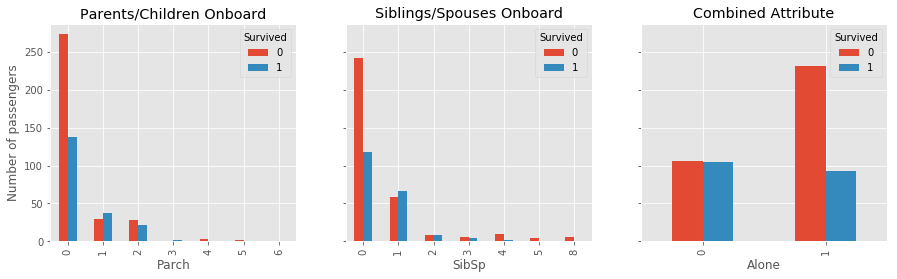

In [95]:
fig, ax = plt.subplots(nrows=1,ncols=3,sharey="row",figsize=(15,4))
pd.crosstab(df["Parch"],df["Survived"]).plot(kind='bar',ax=ax[0],title="Parents/Children Onboard")
pd.crosstab(df["SibSp"],df["Survived"]).plot(kind='bar',ax=ax[1],title="Siblings/Spouses Onboard")
pd.crosstab(df["Alone"],df["Survived"]).plot(kind='bar',ax=ax[2],title="Combined Attribute")
ax[0].set_ylabel("Number of passengers")
plt.show()

In [ ]:
pd.crosstab(train["Alone"],train["Survived"]).plot(kind='bar')

### Under 5 Years of Age

This graphs shows another custom feature, which is ___true___ if the passenger is less than 5 and ___false___ if the passenger is older. As we can see here, this feature doesn't really add any value to our model, as the distribution of survivors and non-survivors is quite similar in both cases.

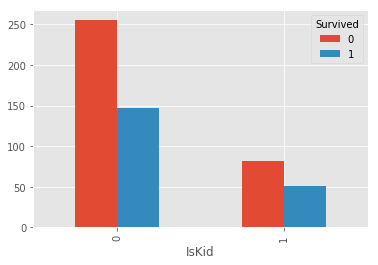

In [96]:
pd.crosstab(train["IsKid"],train["Survived"]).plot(kind='bar')

### Embarked / Passenger Class

The Titanic collected passengers at three different ports before setting across the Atlantic, the highest concentration being at Southampton. Initially, it would appear as though the passengers who boarded in Cherbourg had a higher chance of survival, but a closer look indicates that this is more likely to be a spurious relationship, as majority of the passengers who boarded in Cherbourg were 1st class passengers, who themselves had a much higher chance of surviving the Titanic when compared to the other two classes. Nevertheless, the "Embarkment" variable will be included in the final model to give extra dimensionality.

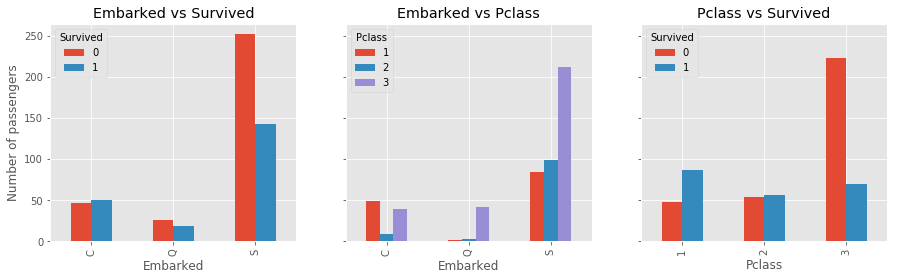

In [299]:
fig, ax = plt.subplots(nrows=1,ncols=3,sharey="row",figsize=(15,4))

pd.crosstab(train["Embarked"],train["Survived"]).plot(kind='bar',ax=ax[0],title="Embarked vs Survived")
pd.crosstab(train["Embarked"],train["Pclass"]).plot(kind='bar',ax=ax[1],title="Embarked vs Pclass")
pd.crosstab(train["Pclass"],train["Survived"]).plot(kind='bar',ax=ax[2],title="Pclass vs Survived")
ax[0].set_ylabel("Number of passengers")
plt.show()


### Age and it's relation to class and survival

Lastly, before assembling the model, I looked at the distribution of Age in relation to both class and survival.

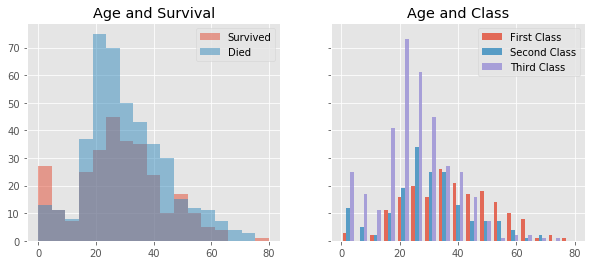

In [318]:
fig, ax = plt.subplots(nrows=1,ncols=2,sharey="row",figsize=(10,4))

# Age and survival
#df.dropna(inplace=True)
#print(np.linspace(0,80,9))
ax[0].hist(df.loc[(df["Survived"]==1)&(df["Age"]!=np.mean(df["Age"])),"Age"].values,np.linspace(0,80,18),label="Survived",alpha=0.5)
ax[0].hist(df.loc[(df["Survived"]==0)&(df["Age"]!=np.mean(df["Age"])),"Age"].values,np.linspace(0,80,18),label="Died",alpha=0.5)
ax[0].legend(loc="upper right")
ax[0].set_title(label="Age and Survival")
#plt.show()

# Age and Pclass

data = [df.loc[(df["Pclass"]==1) & (df["Age"] != np.mean(df["Age"])),"Age"].values,df.loc[(df["Pclass"]==2) & (df["Age"] != np.mean(df["Age"])),"Age"].values,df.loc[(df["Pclass"]==3) & (df["Age"] != np.mean(df["Age"])),"Age"].values]
bins = np.linspace(0,80,18)
ax[1].hist(data,bins,alpha=0.8,label=["First Class","Second Class","Third Class"])
ax[1].legend(loc="upper right")
ax[1].set_title(label="Age and Class")
plt.show()

In [ ]:
#### start of modelling

In [268]:
df = applyTransformations(df)

In [271]:
test, train = split(df,test_ratio=0.4)

In [286]:
# define variable columns

y = ["Survived"]
x_bool_complete = ["1","2","3","Q","S","C","Age","male","female","IsKid","Alone","Fare"]


kfold = model_selection.KFold(n_splits=10,random_state=7)
scoring = 'accuracy'
num_trees = 100

train_data = train[x_bool_complete]
labels = np.array(train[y]).astype(int).ravel()

# Logistic Regression

modelCV = LogisticRegression()
logreg_results = model_selection.cross_val_score(modelCV,train_data,labels,cv=kfold,scoring=scoring)
#print("10-fold cross val accuracy: ",logreg1_results)


# Decision Tree

dt = tree.DecisionTreeClassifier(criterion='gini',max_depth=8)
dt_results = model_selection.cross_val_score(dt,train_data,labels,cv=kfold)

#dt.fit(train[x_bool_complete],train[y])

#print("Result of Decision Tree classifier: ",dt_results.mean())

#train_dt_predict = dt.predict(train[x_bool_complete])
#test_dt_predict = dt.predict(test[x_bool_complete])


# Bagging

dt2 = tree.DecisionTreeClassifier()

bag_model = BaggingClassifier(base_estimator=dt2,n_estimators=num_trees)
bag_results = model_selection.cross_val_score(bag_model,train_data,labels,cv=kfold)
#print(bag_results.mean())


# Random Forest

max_features = 5
rf_model = RandomForestClassifier(n_estimators=num_trees,max_features=max_features)
rf_results = model_selection.cross_val_score(rf_model,train_data,labels,cv=kfold)
#print(rf_results.mean())


# Ada-Boost

ada_boost_model = AdaBoostClassifier(n_estimators=num_trees)
ada_boost_results = model_selection.cross_val_score(ada_boost_model,train_data,labels,cv=kfold)



# Gradient Boost

grad_boost_model = GradientBoostingClassifier(n_estimators=num_trees)
grad_boost_results = model_selection.cross_val_score(grad_boost_model,train_data,labels,cv=kfold)


all_results = [logreg_results,dt_results,bag_results,rf_results,ada_boost_results,grad_boost_results]


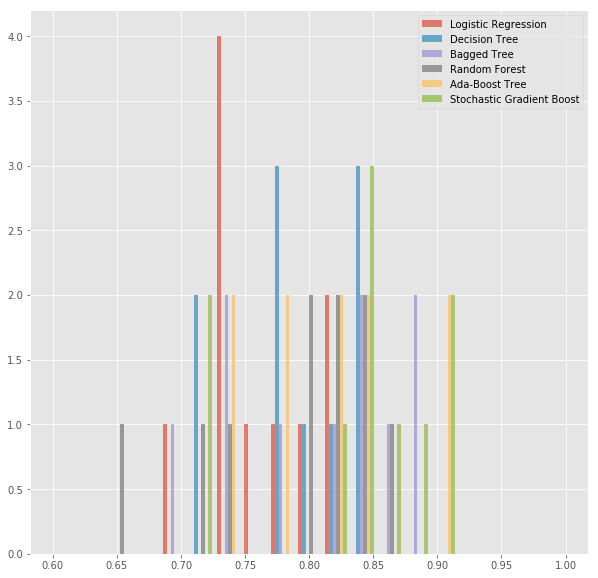

In [288]:
# now plot the results


plt.figure(figsize=(10,10))
plt.hist(all_results,bins=np.linspace(0.6,1,20),alpha=0.7,label=["Logistic Regression","Decision Tree","Bagged Tree","Random Forest","Ada-Boost Tree","Stochastic Gradient Boost"])
plt.legend(loc="upper right")
plt.show()


In [289]:

### NEURAL NETWORK ###
import tensorflow
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation

nn = Sequential()
nn.add(Dense(12, input_dim=12,activation='relu'))
nn.add(Dense(12,activation='relu'))
nn.add(Dense(12,activation='relu'))
nn.add(Dense(12,activation='relu'))
nn.add(Dense(12,activation='relu'))
nn.add(Dense(1,activation='sigmoid'))

adam_opt = keras.optimizers.Adam(lr=0.001,beta_1=0.9,beta_2=0.999, epsilon=None, decay=0.0)

def cross_entr(y_true,y_pred):
    return(keras.losses.binary_crossentropy(y_true,y_pred))

def mean_pred(y_true,y_pred):
    return(np.mean(y_pred))

nn.compile(loss=cross_entr, optimizer=adam_opt, metrics=["mae"])

nn.fit(train[x_bool_complete],train[y],batch_size=200,epochs=5000)

y_pred = nn.predict(train[x_bool_complete])
y_pred = [1 if x > 0.5 else 0 for x in y_pred]
accuracy_score(y_pred,train[y])




Epoch 1/5000
535/535 [==============================] - 1s 2ms/step - loss: 0.6960 - mean_absolute_error: 0.5009
Epoch 2/5000
535/535 [==============================] - 0s 10us/step - loss: 0.6903 - mean_absolute_error: 0.4978
Epoch 3/5000
535/535 [==============================] - 0s 10us/step - loss: 0.6845 - mean_absolute_error: 0.4946
Epoch 4/5000
535/535 [==============================] - 0s 11us/step - loss: 0.6800 - mean_absolute_error: 0.4921
Epoch 5/5000
535/535 [==============================] - 0s 12us/step - loss: 0.6754 - mean_absolute_error: 0.4894
Epoch 6/5000
535/535 [==============================] - 0s 10us/step - loss: 0.6708 - mean_absolute_error: 0.4866
Epoch 7/5000
535/535 [==============================] - 0s 10us/step - loss: 0.6657 - mean_absolute_error: 0.4836
Epoch 8/5000
535/535 [==============================] - 0s 11us/step - loss: 0.6606 - mean_absolute_error: 0.4803
Epoch 9/5000
535/535 [==============================] - 0s 10us/step - loss: 0.6550 - mea

535/535 [==============================] - 0s 10us/step - loss: 0.4184 - mean_absolute_error: 0.2664
Epoch 73/5000
535/535 [==============================] - 0s 11us/step - loss: 0.4180 - mean_absolute_error: 0.2666
Epoch 74/5000
535/535 [==============================] - 0s 11us/step - loss: 0.4171 - mean_absolute_error: 0.2656
Epoch 75/5000
535/535 [==============================] - 0s 10us/step - loss: 0.4169 - mean_absolute_error: 0.2644
Epoch 76/5000
535/535 [==============================] - 0s 10us/step - loss: 0.4168 - mean_absolute_error: 0.2632
Epoch 77/5000
535/535 [==============================] - 0s 10us/step - loss: 0.4162 - mean_absolute_error: 0.2631
Epoch 78/5000
535/535 [==============================] - 0s 10us/step - loss: 0.4158 - mean_absolute_error: 0.2637
Epoch 79/5000
535/535 [==============================] - 0s 10us/step - loss: 0.4155 - mean_absolute_error: 0.2638
Epoch 80/5000
535/535 [==============================] - 0s 10us/step - loss: 0.4151 - mean_ab

535/535 [==============================] - 0s 9us/step - loss: 0.3985 - mean_absolute_error: 0.2527
Epoch 144/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3981 - mean_absolute_error: 0.2526
Epoch 145/5000
535/535 [==============================] - 0s 9us/step - loss: 0.3982 - mean_absolute_error: 0.2526
Epoch 146/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3975 - mean_absolute_error: 0.2517
Epoch 147/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3974 - mean_absolute_error: 0.2508
Epoch 148/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3971 - mean_absolute_error: 0.2505
Epoch 149/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3969 - mean_absolute_error: 0.2506
Epoch 150/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3969 - mean_absolute_error: 0.2513
Epoch 151/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3964 - m

535/535 [==============================] - 0s 10us/step - loss: 0.3841 - mean_absolute_error: 0.2438
Epoch 214/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3837 - mean_absolute_error: 0.2432
Epoch 215/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3835 - mean_absolute_error: 0.2424
Epoch 216/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3835 - mean_absolute_error: 0.2422
Epoch 217/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3832 - mean_absolute_error: 0.2419
Epoch 218/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3832 - mean_absolute_error: 0.2419
Epoch 219/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3832 - mean_absolute_error: 0.2422
Epoch 220/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3830 - mean_absolute_error: 0.2421
Epoch 221/5000
535/535 [==============================] - 0s 14us/step - loss: 0.3826 -

535/535 [==============================] - 0s 11us/step - loss: 0.3738 - mean_absolute_error: 0.2348
Epoch 284/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3738 - mean_absolute_error: 0.2377
Epoch 285/5000
535/535 [==============================] - 0s 12us/step - loss: 0.3746 - mean_absolute_error: 0.2395
Epoch 286/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3734 - mean_absolute_error: 0.2371
Epoch 287/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3736 - mean_absolute_error: 0.2351
Epoch 288/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3735 - mean_absolute_error: 0.2353
Epoch 289/5000
535/535 [==============================] - 0s 13us/step - loss: 0.3735 - mean_absolute_error: 0.2363
Epoch 290/5000
535/535 [==============================] - 0s 9us/step - loss: 0.3735 - mean_absolute_error: 0.2384
Epoch 291/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3739 - 

535/535 [==============================] - 0s 10us/step - loss: 0.3671 - mean_absolute_error: 0.2347
Epoch 354/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3674 - mean_absolute_error: 0.2354
Epoch 355/5000
535/535 [==============================] - 0s 12us/step - loss: 0.3673 - mean_absolute_error: 0.2325
Epoch 356/5000
535/535 [==============================] - 0s 13us/step - loss: 0.3673 - mean_absolute_error: 0.2307
Epoch 357/5000
535/535 [==============================] - 0s 12us/step - loss: 0.3663 - mean_absolute_error: 0.2307
Epoch 358/5000
535/535 [==============================] - 0s 13us/step - loss: 0.3672 - mean_absolute_error: 0.2328
Epoch 359/5000
535/535 [==============================] - 0s 9us/step - loss: 0.3668 - mean_absolute_error: 0.2338
Epoch 360/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3659 - mean_absolute_error: 0.2331
Epoch 361/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3660 - 

535/535 [==============================] - 0s 13us/step - loss: 0.3608 - mean_absolute_error: 0.2294
Epoch 424/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3609 - mean_absolute_error: 0.2283
Epoch 425/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3611 - mean_absolute_error: 0.2275
Epoch 426/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3607 - mean_absolute_error: 0.2287
Epoch 427/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3610 - mean_absolute_error: 0.2304
Epoch 428/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3607 - mean_absolute_error: 0.2295
Epoch 429/5000
535/535 [==============================] - 0s 12us/step - loss: 0.3610 - mean_absolute_error: 0.2286
Epoch 430/5000
535/535 [==============================] - 0s 12us/step - loss: 0.3609 - mean_absolute_error: 0.2284
Epoch 431/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3604 -

535/535 [==============================] - 0s 10us/step - loss: 0.3544 - mean_absolute_error: 0.2274
Epoch 494/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3540 - mean_absolute_error: 0.2249
Epoch 495/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3537 - mean_absolute_error: 0.2249
Epoch 496/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3537 - mean_absolute_error: 0.2267
Epoch 497/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3536 - mean_absolute_error: 0.2274
Epoch 498/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3544 - mean_absolute_error: 0.2253
Epoch 499/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3545 - mean_absolute_error: 0.2249
Epoch 500/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3538 - mean_absolute_error: 0.2248
Epoch 501/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3537 -

535/535 [==============================] - 0s 12us/step - loss: 0.3463 - mean_absolute_error: 0.2236
Epoch 564/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3467 - mean_absolute_error: 0.2220
Epoch 565/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3469 - mean_absolute_error: 0.2215
Epoch 566/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3463 - mean_absolute_error: 0.2209
Epoch 567/5000
535/535 [==============================] - 0s 13us/step - loss: 0.3461 - mean_absolute_error: 0.2207
Epoch 568/5000
535/535 [==============================] - 0s 14us/step - loss: 0.3462 - mean_absolute_error: 0.2213
Epoch 569/5000
535/535 [==============================] - 0s 14us/step - loss: 0.3461 - mean_absolute_error: 0.2219
Epoch 570/5000
535/535 [==============================] - 0s 14us/step - loss: 0.3455 - mean_absolute_error: 0.2209
Epoch 571/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3457 -

535/535 [==============================] - 0s 10us/step - loss: 0.3397 - mean_absolute_error: 0.2163
Epoch 634/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3388 - mean_absolute_error: 0.2174
Epoch 635/5000
535/535 [==============================] - 0s 9us/step - loss: 0.3391 - mean_absolute_error: 0.2203
Epoch 636/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3386 - mean_absolute_error: 0.2193
Epoch 637/5000
535/535 [==============================] - 0s 12us/step - loss: 0.3389 - mean_absolute_error: 0.2174
Epoch 638/5000
535/535 [==============================] - 0s 12us/step - loss: 0.3391 - mean_absolute_error: 0.2181
Epoch 639/5000
535/535 [==============================] - 0s 9us/step - loss: 0.3380 - mean_absolute_error: 0.2182
Epoch 640/5000
535/535 [==============================] - 0s 9us/step - loss: 0.3385 - mean_absolute_error: 0.2175
Epoch 641/5000
535/535 [==============================] - 0s 9us/step - loss: 0.3391 - mea

535/535 [==============================] - 0s 11us/step - loss: 0.3339 - mean_absolute_error: 0.2151
Epoch 704/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3332 - mean_absolute_error: 0.2145
Epoch 705/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3327 - mean_absolute_error: 0.2128
Epoch 706/5000
535/535 [==============================] - 0s 16us/step - loss: 0.3326 - mean_absolute_error: 0.2128
Epoch 707/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3323 - mean_absolute_error: 0.2138
Epoch 708/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3316 - mean_absolute_error: 0.2140
Epoch 709/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3320 - mean_absolute_error: 0.2137
Epoch 710/5000
535/535 [==============================] - 0s 9us/step - loss: 0.3334 - mean_absolute_error: 0.2147
Epoch 711/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3320 - 

535/535 [==============================] - 0s 10us/step - loss: 0.3278 - mean_absolute_error: 0.2105
Epoch 774/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3282 - mean_absolute_error: 0.2121
Epoch 775/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3277 - mean_absolute_error: 0.2106
Epoch 776/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3270 - mean_absolute_error: 0.2086
Epoch 777/5000
535/535 [==============================] - 0s 12us/step - loss: 0.3281 - mean_absolute_error: 0.2087
Epoch 778/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3267 - mean_absolute_error: 0.2096
Epoch 779/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3273 - mean_absolute_error: 0.2112
Epoch 780/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3282 - mean_absolute_error: 0.2109
Epoch 781/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3269 -

535/535 [==============================] - 0s 11us/step - loss: 0.3226 - mean_absolute_error: 0.2056
Epoch 844/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3229 - mean_absolute_error: 0.2058
Epoch 845/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3224 - mean_absolute_error: 0.2060
Epoch 846/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3227 - mean_absolute_error: 0.2073
Epoch 847/5000
535/535 [==============================] - 0s 13us/step - loss: 0.3224 - mean_absolute_error: 0.2074
Epoch 848/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3223 - mean_absolute_error: 0.2075
Epoch 849/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3228 - mean_absolute_error: 0.2084
Epoch 850/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3228 - mean_absolute_error: 0.2097
Epoch 851/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3223 -

535/535 [==============================] - 0s 11us/step - loss: 0.3193 - mean_absolute_error: 0.2080
Epoch 914/5000
535/535 [==============================] - 0s 12us/step - loss: 0.3187 - mean_absolute_error: 0.2052
Epoch 915/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3187 - mean_absolute_error: 0.2035
Epoch 916/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3184 - mean_absolute_error: 0.2045
Epoch 917/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3212 - mean_absolute_error: 0.2035
Epoch 918/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3172 - mean_absolute_error: 0.2020
Epoch 919/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3201 - mean_absolute_error: 0.2064
Epoch 920/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3208 - mean_absolute_error: 0.2066
Epoch 921/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3182 -

535/535 [==============================] - 0s 10us/step - loss: 0.3139 - mean_absolute_error: 0.2038
Epoch 984/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3140 - mean_absolute_error: 0.2043
Epoch 985/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3155 - mean_absolute_error: 0.2018
Epoch 986/5000
535/535 [==============================] - 0s 12us/step - loss: 0.3152 - mean_absolute_error: 0.2030
Epoch 987/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3147 - mean_absolute_error: 0.2054
Epoch 988/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3168 - mean_absolute_error: 0.2037
Epoch 989/5000
535/535 [==============================] - 0s 18us/step - loss: 0.3138 - mean_absolute_error: 0.2024
Epoch 990/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3152 - mean_absolute_error: 0.2036
Epoch 991/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3146 -

535/535 [==============================] - 0s 10us/step - loss: 0.3112 - mean_absolute_error: 0.2030
Epoch 1054/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3121 - mean_absolute_error: 0.2019
Epoch 1055/5000
535/535 [==============================] - 0s 12us/step - loss: 0.3115 - mean_absolute_error: 0.1987
Epoch 1056/5000
535/535 [==============================] - 0s 12us/step - loss: 0.3103 - mean_absolute_error: 0.1971
Epoch 1057/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3129 - mean_absolute_error: 0.1990
Epoch 1058/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3107 - mean_absolute_error: 0.1995
Epoch 1059/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3114 - mean_absolute_error: 0.1996
Epoch 1060/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3106 - mean_absolute_error: 0.1990
Epoch 1061/5000
535/535 [==============================] - 0s 10us/step - loss: 

535/535 [==============================] - 0s 11us/step - loss: 0.3054 - mean_absolute_error: 0.1961
Epoch 1124/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3087 - mean_absolute_error: 0.1995
Epoch 1125/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3106 - mean_absolute_error: 0.1988
Epoch 1126/5000
535/535 [==============================] - 0s 12us/step - loss: 0.3068 - mean_absolute_error: 0.1974
Epoch 1127/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3076 - mean_absolute_error: 0.2030
Epoch 1128/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3064 - mean_absolute_error: 0.2016
Epoch 1129/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3063 - mean_absolute_error: 0.1963
Epoch 1130/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3090 - mean_absolute_error: 0.1981
Epoch 1131/5000
535/535 [==============================] - 0s 10us/step - loss: 

535/535 [==============================] - 0s 11us/step - loss: 0.3023 - mean_absolute_error: 0.1962
Epoch 1194/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3021 - mean_absolute_error: 0.1950
Epoch 1195/5000
535/535 [==============================] - 0s 13us/step - loss: 0.3020 - mean_absolute_error: 0.1949
Epoch 1196/5000
535/535 [==============================] - 0s 12us/step - loss: 0.3050 - mean_absolute_error: 0.1947
Epoch 1197/5000
535/535 [==============================] - 0s 12us/step - loss: 0.3016 - mean_absolute_error: 0.1941
Epoch 1198/5000
535/535 [==============================] - 0s 14us/step - loss: 0.3019 - mean_absolute_error: 0.1952
Epoch 1199/5000
535/535 [==============================] - 0s 12us/step - loss: 0.3051 - mean_absolute_error: 0.1968
Epoch 1200/5000
535/535 [==============================] - 0s 14us/step - loss: 0.3057 - mean_absolute_error: 0.1938
Epoch 1201/5000
535/535 [==============================] - 0s 12us/step - loss: 

535/535 [==============================] - 0s 10us/step - loss: 0.2979 - mean_absolute_error: 0.1927
Epoch 1264/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2991 - mean_absolute_error: 0.1904
Epoch 1265/5000
535/535 [==============================] - 0s 13us/step - loss: 0.2995 - mean_absolute_error: 0.1926
Epoch 1266/5000
535/535 [==============================] - 0s 13us/step - loss: 0.2970 - mean_absolute_error: 0.1936
Epoch 1267/5000
535/535 [==============================] - 0s 14us/step - loss: 0.3002 - mean_absolute_error: 0.1927
Epoch 1268/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2984 - mean_absolute_error: 0.1927
Epoch 1269/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3020 - mean_absolute_error: 0.1961
Epoch 1270/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2975 - mean_absolute_error: 0.1911
Epoch 1271/5000
535/535 [==============================] - 0s 11us/step - loss: 

535/535 [==============================] - 0s 9us/step - loss: 0.2923 - mean_absolute_error: 0.1904
Epoch 1334/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2922 - mean_absolute_error: 0.1897
Epoch 1335/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2929 - mean_absolute_error: 0.1890
Epoch 1336/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2935 - mean_absolute_error: 0.1900
Epoch 1337/5000
535/535 [==============================] - 0s 9us/step - loss: 0.2931 - mean_absolute_error: 0.1912
Epoch 1338/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2921 - mean_absolute_error: 0.1920
Epoch 1339/5000
535/535 [==============================] - 0s 13us/step - loss: 0.2950 - mean_absolute_error: 0.1919
Epoch 1340/5000
535/535 [==============================] - 0s 9us/step - loss: 0.2916 - mean_absolute_error: 0.1888
Epoch 1341/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2

535/535 [==============================] - 0s 11us/step - loss: 0.2913 - mean_absolute_error: 0.1855
Epoch 1404/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2891 - mean_absolute_error: 0.1871
Epoch 1405/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2899 - mean_absolute_error: 0.1874
Epoch 1406/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2895 - mean_absolute_error: 0.1840
Epoch 1407/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2927 - mean_absolute_error: 0.1886
Epoch 1408/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2893 - mean_absolute_error: 0.1906
Epoch 1409/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2922 - mean_absolute_error: 0.1876
Epoch 1410/5000
535/535 [==============================] - 0s 13us/step - loss: 0.2907 - mean_absolute_error: 0.1854
Epoch 1411/5000
535/535 [==============================] - 0s 13us/step - loss: 

535/535 [==============================] - 0s 11us/step - loss: 0.2849 - mean_absolute_error: 0.1829
Epoch 1474/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2850 - mean_absolute_error: 0.1850
Epoch 1475/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2853 - mean_absolute_error: 0.1861
Epoch 1476/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2859 - mean_absolute_error: 0.1856
Epoch 1477/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2865 - mean_absolute_error: 0.1860
Epoch 1478/5000
535/535 [==============================] - 0s 13us/step - loss: 0.2846 - mean_absolute_error: 0.1846
Epoch 1479/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2859 - mean_absolute_error: 0.1822
Epoch 1480/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2852 - mean_absolute_error: 0.1820
Epoch 1481/5000
535/535 [==============================] - 0s 10us/step - loss: 

535/535 [==============================] - 0s 10us/step - loss: 0.2829 - mean_absolute_error: 0.1812
Epoch 1544/5000
535/535 [==============================] - 0s 13us/step - loss: 0.2831 - mean_absolute_error: 0.1812
Epoch 1545/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2877 - mean_absolute_error: 0.1803
Epoch 1546/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2823 - mean_absolute_error: 0.1796
Epoch 1547/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2889 - mean_absolute_error: 0.1879
Epoch 1548/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2811 - mean_absolute_error: 0.1840
Epoch 1549/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2876 - mean_absolute_error: 0.1839
Epoch 1550/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2815 - mean_absolute_error: 0.1813
Epoch 1551/5000
535/535 [==============================] - 0s 12us/step - loss: 

535/535 [==============================] - 0s 11us/step - loss: 0.2775 - mean_absolute_error: 0.1801
Epoch 1614/5000
535/535 [==============================] - 0s 13us/step - loss: 0.2788 - mean_absolute_error: 0.1833
Epoch 1615/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2766 - mean_absolute_error: 0.1800
Epoch 1616/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2793 - mean_absolute_error: 0.1775
Epoch 1617/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2789 - mean_absolute_error: 0.1813
Epoch 1618/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2783 - mean_absolute_error: 0.1823
Epoch 1619/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2786 - mean_absolute_error: 0.1779
Epoch 1620/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2776 - mean_absolute_error: 0.1772
Epoch 1621/5000
535/535 [==============================] - 0s 10us/step - loss: 

535/535 [==============================] - 0s 11us/step - loss: 0.2741 - mean_absolute_error: 0.1758
Epoch 1684/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2742 - mean_absolute_error: 0.1762
Epoch 1685/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2741 - mean_absolute_error: 0.1777
Epoch 1686/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2739 - mean_absolute_error: 0.1759
Epoch 1687/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2732 - mean_absolute_error: 0.1748
Epoch 1688/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2757 - mean_absolute_error: 0.1755
Epoch 1689/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2734 - mean_absolute_error: 0.1751
Epoch 1690/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2750 - mean_absolute_error: 0.1782
Epoch 1691/5000
535/535 [==============================] - 0s 10us/step - loss: 

535/535 [==============================] - 0s 9us/step - loss: 0.2737 - mean_absolute_error: 0.1734
Epoch 1754/5000
535/535 [==============================] - 0s 9us/step - loss: 0.2720 - mean_absolute_error: 0.1751
Epoch 1755/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2727 - mean_absolute_error: 0.1760
Epoch 1756/5000
535/535 [==============================] - 0s 13us/step - loss: 0.2719 - mean_absolute_error: 0.1739
Epoch 1757/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2707 - mean_absolute_error: 0.1739
Epoch 1758/5000
535/535 [==============================] - 0s 9us/step - loss: 0.2739 - mean_absolute_error: 0.1755
Epoch 1759/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2733 - mean_absolute_error: 0.1753
Epoch 1760/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2749 - mean_absolute_error: 0.1757
Epoch 1761/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2

535/535 [==============================] - 0s 10us/step - loss: 0.2763 - mean_absolute_error: 0.1789
Epoch 1824/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2719 - mean_absolute_error: 0.1733
Epoch 1825/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2715 - mean_absolute_error: 0.1709
Epoch 1826/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2694 - mean_absolute_error: 0.1715
Epoch 1827/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2697 - mean_absolute_error: 0.1700
Epoch 1828/5000
535/535 [==============================] - 0s 9us/step - loss: 0.2693 - mean_absolute_error: 0.1698
Epoch 1829/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2673 - mean_absolute_error: 0.1717
Epoch 1830/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2694 - mean_absolute_error: 0.1738
Epoch 1831/5000
535/535 [==============================] - 0s 11us/step - loss: 0

535/535 [==============================] - 0s 10us/step - loss: 0.2708 - mean_absolute_error: 0.1709
Epoch 1894/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2699 - mean_absolute_error: 0.1701
Epoch 1895/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2708 - mean_absolute_error: 0.1740
Epoch 1896/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2726 - mean_absolute_error: 0.1707
Epoch 1897/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2685 - mean_absolute_error: 0.1685
Epoch 1898/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2715 - mean_absolute_error: 0.1759
Epoch 1899/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2667 - mean_absolute_error: 0.1732
Epoch 1900/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2676 - mean_absolute_error: 0.1695
Epoch 1901/5000
535/535 [==============================] - 0s 11us/step - loss: 

535/535 [==============================] - 0s 10us/step - loss: 0.2644 - mean_absolute_error: 0.1708
Epoch 1964/5000
535/535 [==============================] - 0s 13us/step - loss: 0.2666 - mean_absolute_error: 0.1683
Epoch 1965/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2644 - mean_absolute_error: 0.1683
Epoch 1966/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2670 - mean_absolute_error: 0.1742
Epoch 1967/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2647 - mean_absolute_error: 0.1701
Epoch 1968/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2675 - mean_absolute_error: 0.1670
Epoch 1969/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2624 - mean_absolute_error: 0.1676
Epoch 1970/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2662 - mean_absolute_error: 0.1688
Epoch 1971/5000
535/535 [==============================] - 0s 10us/step - loss: 

535/535 [==============================] - 0s 14us/step - loss: 0.2645 - mean_absolute_error: 0.1683
Epoch 2034/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2635 - mean_absolute_error: 0.1696
Epoch 2035/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2634 - mean_absolute_error: 0.1690
Epoch 2036/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2631 - mean_absolute_error: 0.1659
Epoch 2037/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2636 - mean_absolute_error: 0.1657
Epoch 2038/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2649 - mean_absolute_error: 0.1700
Epoch 2039/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2641 - mean_absolute_error: 0.1694
Epoch 2040/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2646 - mean_absolute_error: 0.1654
Epoch 2041/5000
535/535 [==============================] - 0s 15us/step - loss: 

535/535 [==============================] - 0s 10us/step - loss: 0.2743 - mean_absolute_error: 0.1741
Epoch 2104/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2680 - mean_absolute_error: 0.1700
Epoch 2105/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2658 - mean_absolute_error: 0.1637
Epoch 2106/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2664 - mean_absolute_error: 0.1652
Epoch 2107/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2633 - mean_absolute_error: 0.1672
Epoch 2108/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2671 - mean_absolute_error: 0.1670
Epoch 2109/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2629 - mean_absolute_error: 0.1659
Epoch 2110/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2623 - mean_absolute_error: 0.1654
Epoch 2111/5000
535/535 [==============================] - 0s 11us/step - loss: 

535/535 [==============================] - 0s 13us/step - loss: 0.2642 - mean_absolute_error: 0.1656
Epoch 2174/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2583 - mean_absolute_error: 0.1633
Epoch 2175/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2616 - mean_absolute_error: 0.1644
Epoch 2176/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2613 - mean_absolute_error: 0.1634
Epoch 2177/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2590 - mean_absolute_error: 0.1646
Epoch 2178/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2632 - mean_absolute_error: 0.1719
Epoch 2179/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2603 - mean_absolute_error: 0.1687
Epoch 2180/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2581 - mean_absolute_error: 0.1641
Epoch 2181/5000
535/535 [==============================] - 0s 11us/step - loss: 

535/535 [==============================] - 0s 10us/step - loss: 0.2572 - mean_absolute_error: 0.1637
Epoch 2244/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2596 - mean_absolute_error: 0.1636
Epoch 2245/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2580 - mean_absolute_error: 0.1630
Epoch 2246/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2581 - mean_absolute_error: 0.1644
Epoch 2247/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2580 - mean_absolute_error: 0.1652
Epoch 2248/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2566 - mean_absolute_error: 0.1642
Epoch 2249/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2584 - mean_absolute_error: 0.1650
Epoch 2250/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2585 - mean_absolute_error: 0.1658
Epoch 2251/5000
535/535 [==============================] - 0s 10us/step - loss: 

535/535 [==============================] - 0s 10us/step - loss: 0.2563 - mean_absolute_error: 0.1621
Epoch 2314/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2570 - mean_absolute_error: 0.1597
Epoch 2315/5000
535/535 [==============================] - 0s 13us/step - loss: 0.2582 - mean_absolute_error: 0.1648
Epoch 2316/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2589 - mean_absolute_error: 0.1673
Epoch 2317/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2579 - mean_absolute_error: 0.1631
Epoch 2318/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2566 - mean_absolute_error: 0.1619
Epoch 2319/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2567 - mean_absolute_error: 0.1660
Epoch 2320/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2585 - mean_absolute_error: 0.1666
Epoch 2321/5000
535/535 [==============================] - 0s 10us/step - loss: 

535/535 [==============================] - 0s 10us/step - loss: 0.2556 - mean_absolute_error: 0.1599
Epoch 2384/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2576 - mean_absolute_error: 0.1640
Epoch 2385/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2527 - mean_absolute_error: 0.1600
Epoch 2386/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2564 - mean_absolute_error: 0.1608
Epoch 2387/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2542 - mean_absolute_error: 0.1618
Epoch 2388/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2570 - mean_absolute_error: 0.1619
Epoch 2389/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2558 - mean_absolute_error: 0.1625
Epoch 2390/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2568 - mean_absolute_error: 0.1630
Epoch 2391/5000
535/535 [==============================] - 0s 10us/step - loss: 

535/535 [==============================] - 0s 11us/step - loss: 0.2545 - mean_absolute_error: 0.1615
Epoch 2454/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2528 - mean_absolute_error: 0.1609
Epoch 2455/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2528 - mean_absolute_error: 0.1602
Epoch 2456/5000
535/535 [==============================] - 0s 9us/step - loss: 0.2524 - mean_absolute_error: 0.1593
Epoch 2457/5000
535/535 [==============================] - 0s 17us/step - loss: 0.2529 - mean_absolute_error: 0.1588
Epoch 2458/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2538 - mean_absolute_error: 0.1609
Epoch 2459/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2532 - mean_absolute_error: 0.1596
Epoch 2460/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2531 - mean_absolute_error: 0.1571
Epoch 2461/5000
535/535 [==============================] - 0s 10us/step - loss: 0

535/535 [==============================] - 0s 10us/step - loss: 0.2522 - mean_absolute_error: 0.1578
Epoch 2524/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2538 - mean_absolute_error: 0.1611
Epoch 2525/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2516 - mean_absolute_error: 0.1602
Epoch 2526/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2529 - mean_absolute_error: 0.1586
Epoch 2527/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2550 - mean_absolute_error: 0.1597
Epoch 2528/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2540 - mean_absolute_error: 0.1597
Epoch 2529/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2539 - mean_absolute_error: 0.1605
Epoch 2530/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2531 - mean_absolute_error: 0.1619
Epoch 2531/5000
535/535 [==============================] - 0s 10us/step - loss: 

535/535 [==============================] - 0s 14us/step - loss: 0.2493 - mean_absolute_error: 0.1580
Epoch 2594/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2515 - mean_absolute_error: 0.1601
Epoch 2595/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2525 - mean_absolute_error: 0.1623
Epoch 2596/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2503 - mean_absolute_error: 0.1599
Epoch 2597/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2535 - mean_absolute_error: 0.1568
Epoch 2598/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2513 - mean_absolute_error: 0.1572
Epoch 2599/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2511 - mean_absolute_error: 0.1587
Epoch 2600/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2488 - mean_absolute_error: 0.1579
Epoch 2601/5000
535/535 [==============================] - 0s 10us/step - loss: 

535/535 [==============================] - 0s 14us/step - loss: 0.2492 - mean_absolute_error: 0.1580
Epoch 2664/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2520 - mean_absolute_error: 0.1577
Epoch 2665/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2491 - mean_absolute_error: 0.1569
Epoch 2666/5000
535/535 [==============================] - 0s 17us/step - loss: 0.2508 - mean_absolute_error: 0.1572
Epoch 2667/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2481 - mean_absolute_error: 0.1563
Epoch 2668/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2518 - mean_absolute_error: 0.1603
Epoch 2669/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2473 - mean_absolute_error: 0.1592
Epoch 2670/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2524 - mean_absolute_error: 0.1577
Epoch 2671/5000
535/535 [==============================] - 0s 11us/step - loss: 

535/535 [==============================] - 0s 9us/step - loss: 0.2489 - mean_absolute_error: 0.1586
Epoch 2734/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2512 - mean_absolute_error: 0.1601
Epoch 2735/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2485 - mean_absolute_error: 0.1564
Epoch 2736/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2506 - mean_absolute_error: 0.1566
Epoch 2737/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2473 - mean_absolute_error: 0.1547
Epoch 2738/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2472 - mean_absolute_error: 0.1541
Epoch 2739/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2474 - mean_absolute_error: 0.1560
Epoch 2740/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2477 - mean_absolute_error: 0.1573
Epoch 2741/5000
535/535 [==============================] - 0s 13us/step - loss: 0

535/535 [==============================] - 0s 10us/step - loss: 0.2487 - mean_absolute_error: 0.1575
Epoch 2803/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2590 - mean_absolute_error: 0.1602
Epoch 2804/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2498 - mean_absolute_error: 0.1548
Epoch 2805/5000
535/535 [==============================] - 0s 13us/step - loss: 0.2505 - mean_absolute_error: 0.1579
Epoch 2806/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2496 - mean_absolute_error: 0.1601
Epoch 2807/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2498 - mean_absolute_error: 0.1562
Epoch 2808/5000
535/535 [==============================] - 0s 13us/step - loss: 0.2485 - mean_absolute_error: 0.1542
Epoch 2809/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2540 - mean_absolute_error: 0.1613
Epoch 2810/5000
535/535 [==============================] - 0s 11us/step - loss: 

535/535 [==============================] - 0s 10us/step - loss: 0.2462 - mean_absolute_error: 0.1586
Epoch 2873/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2460 - mean_absolute_error: 0.1566
Epoch 2874/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2467 - mean_absolute_error: 0.1538
Epoch 2875/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2459 - mean_absolute_error: 0.1524
Epoch 2876/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2462 - mean_absolute_error: 0.1566
Epoch 2877/5000
535/535 [==============================] - 0s 14us/step - loss: 0.2464 - mean_absolute_error: 0.1584
Epoch 2878/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2458 - mean_absolute_error: 0.1561
Epoch 2879/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2460 - mean_absolute_error: 0.1550
Epoch 2880/5000
535/535 [==============================] - 0s 11us/step - loss: 

535/535 [==============================] - 0s 10us/step - loss: 0.2442 - mean_absolute_error: 0.1523
Epoch 2943/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2446 - mean_absolute_error: 0.1518
Epoch 2944/5000
535/535 [==============================] - 0s 13us/step - loss: 0.2449 - mean_absolute_error: 0.1540
Epoch 2945/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2486 - mean_absolute_error: 0.1589
Epoch 2946/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2442 - mean_absolute_error: 0.1560
Epoch 2947/5000
535/535 [==============================] - 0s 13us/step - loss: 0.2455 - mean_absolute_error: 0.1553
Epoch 2948/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2440 - mean_absolute_error: 0.1564
Epoch 2949/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2448 - mean_absolute_error: 0.1545
Epoch 2950/5000
535/535 [==============================] - 0s 12us/step - loss: 

535/535 [==============================] - 0s 13us/step - loss: 0.2442 - mean_absolute_error: 0.1568
Epoch 3013/5000
535/535 [==============================] - 0s 13us/step - loss: 0.2434 - mean_absolute_error: 0.1521
Epoch 3014/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2446 - mean_absolute_error: 0.1518
Epoch 3015/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2464 - mean_absolute_error: 0.1566
Epoch 3016/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2443 - mean_absolute_error: 0.1572
Epoch 3017/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2430 - mean_absolute_error: 0.1523
Epoch 3018/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2439 - mean_absolute_error: 0.1514
Epoch 3019/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2430 - mean_absolute_error: 0.1544
Epoch 3020/5000
535/535 [==============================] - 0s 12us/step - loss: 

535/535 [==============================] - 0s 12us/step - loss: 0.2459 - mean_absolute_error: 0.1566
Epoch 3083/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2496 - mean_absolute_error: 0.1592
Epoch 3084/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2427 - mean_absolute_error: 0.1566
Epoch 3085/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2436 - mean_absolute_error: 0.1579
Epoch 3086/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2420 - mean_absolute_error: 0.1549
Epoch 3087/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2422 - mean_absolute_error: 0.1515
Epoch 3088/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2421 - mean_absolute_error: 0.1510
Epoch 3089/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2426 - mean_absolute_error: 0.1549
Epoch 3090/5000
535/535 [==============================] - 0s 10us/step - loss: 

535/535 [==============================] - 0s 11us/step - loss: 0.2437 - mean_absolute_error: 0.1555
Epoch 3153/5000
535/535 [==============================] - 0s 13us/step - loss: 0.2428 - mean_absolute_error: 0.1536
Epoch 3154/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2434 - mean_absolute_error: 0.1523
Epoch 3155/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2424 - mean_absolute_error: 0.1565
Epoch 3156/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2438 - mean_absolute_error: 0.1550
Epoch 3157/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2425 - mean_absolute_error: 0.1516
Epoch 3158/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2413 - mean_absolute_error: 0.1533
Epoch 3159/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2405 - mean_absolute_error: 0.1539
Epoch 3160/5000
535/535 [==============================] - 0s 11us/step - loss: 

535/535 [==============================] - 0s 13us/step - loss: 0.2409 - mean_absolute_error: 0.1514
Epoch 3223/5000
535/535 [==============================] - 0s 13us/step - loss: 0.2464 - mean_absolute_error: 0.1504
Epoch 3224/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2437 - mean_absolute_error: 0.1527
Epoch 3225/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2417 - mean_absolute_error: 0.1538
Epoch 3226/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2421 - mean_absolute_error: 0.1539
Epoch 3227/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2402 - mean_absolute_error: 0.1523
Epoch 3228/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2397 - mean_absolute_error: 0.1516
Epoch 3229/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2397 - mean_absolute_error: 0.1519
Epoch 3230/5000
535/535 [==============================] - 0s 15us/step - loss: 

535/535 [==============================] - 0s 11us/step - loss: 0.2406 - mean_absolute_error: 0.1477
Epoch 3293/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2388 - mean_absolute_error: 0.1494
Epoch 3294/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2390 - mean_absolute_error: 0.1543
Epoch 3295/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2394 - mean_absolute_error: 0.1548
Epoch 3296/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2401 - mean_absolute_error: 0.1512
Epoch 3297/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2420 - mean_absolute_error: 0.1527
Epoch 3298/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2394 - mean_absolute_error: 0.1507
Epoch 3299/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2409 - mean_absolute_error: 0.1497
Epoch 3300/5000
535/535 [==============================] - 0s 11us/step - loss: 

535/535 [==============================] - 0s 11us/step - loss: 0.2380 - mean_absolute_error: 0.1542
Epoch 3363/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2390 - mean_absolute_error: 0.1538
Epoch 3364/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2368 - mean_absolute_error: 0.1515
Epoch 3365/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2376 - mean_absolute_error: 0.1499
Epoch 3366/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2381 - mean_absolute_error: 0.1487
Epoch 3367/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2372 - mean_absolute_error: 0.1489
Epoch 3368/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2374 - mean_absolute_error: 0.1514
Epoch 3369/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2392 - mean_absolute_error: 0.1515
Epoch 3370/5000
535/535 [==============================] - 0s 11us/step - loss: 

535/535 [==============================] - 0s 10us/step - loss: 0.2392 - mean_absolute_error: 0.1529
Epoch 3433/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2374 - mean_absolute_error: 0.1489
Epoch 3434/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2372 - mean_absolute_error: 0.1486
Epoch 3435/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2418 - mean_absolute_error: 0.1545
Epoch 3436/5000
535/535 [==============================] - 0s 13us/step - loss: 0.2348 - mean_absolute_error: 0.1501
Epoch 3437/5000
535/535 [==============================] - 0s 13us/step - loss: 0.2407 - mean_absolute_error: 0.1513
Epoch 3438/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2379 - mean_absolute_error: 0.1522
Epoch 3439/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2392 - mean_absolute_error: 0.1516
Epoch 3440/5000
535/535 [==============================] - 0s 13us/step - loss: 

535/535 [==============================] - 0s 13us/step - loss: 0.2351 - mean_absolute_error: 0.1494
Epoch 3503/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2350 - mean_absolute_error: 0.1471
Epoch 3504/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2357 - mean_absolute_error: 0.1474
Epoch 3505/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2348 - mean_absolute_error: 0.1493
Epoch 3506/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2353 - mean_absolute_error: 0.1502
Epoch 3507/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2340 - mean_absolute_error: 0.1486
Epoch 3508/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2362 - mean_absolute_error: 0.1475
Epoch 3509/5000
535/535 [==============================] - 0s 13us/step - loss: 0.2341 - mean_absolute_error: 0.1479
Epoch 3510/5000
535/535 [==============================] - 0s 13us/step - loss: 

535/535 [==============================] - 0s 11us/step - loss: 0.2328 - mean_absolute_error: 0.1459
Epoch 3573/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2430 - mean_absolute_error: 0.1476
Epoch 3574/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2379 - mean_absolute_error: 0.1522
Epoch 3575/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2371 - mean_absolute_error: 0.1518
Epoch 3576/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2370 - mean_absolute_error: 0.1498
Epoch 3577/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2348 - mean_absolute_error: 0.1511
Epoch 3578/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2369 - mean_absolute_error: 0.1495
Epoch 3579/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2315 - mean_absolute_error: 0.1447
Epoch 3580/5000
535/535 [==============================] - 0s 11us/step - loss: 

535/535 [==============================] - 0s 11us/step - loss: 0.2309 - mean_absolute_error: 0.1452
Epoch 3643/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2301 - mean_absolute_error: 0.1463
Epoch 3644/5000
535/535 [==============================] - 0s 13us/step - loss: 0.2318 - mean_absolute_error: 0.1496
Epoch 3645/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2383 - mean_absolute_error: 0.1489
Epoch 3646/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2302 - mean_absolute_error: 0.1433
Epoch 3647/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2353 - mean_absolute_error: 0.1501
Epoch 3648/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2315 - mean_absolute_error: 0.1473
Epoch 3649/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2340 - mean_absolute_error: 0.1456
Epoch 3650/5000
535/535 [==============================] - 0s 10us/step - loss: 

535/535 [==============================] - 0s 12us/step - loss: 0.2357 - mean_absolute_error: 0.1496
Epoch 3713/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2331 - mean_absolute_error: 0.1488
Epoch 3714/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2372 - mean_absolute_error: 0.1473
Epoch 3715/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2322 - mean_absolute_error: 0.1468
Epoch 3716/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2300 - mean_absolute_error: 0.1459
Epoch 3717/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2340 - mean_absolute_error: 0.1433
Epoch 3718/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2289 - mean_absolute_error: 0.1445
Epoch 3719/5000
535/535 [==============================] - 0s 14us/step - loss: 0.2303 - mean_absolute_error: 0.1500
Epoch 3720/5000
535/535 [==============================] - 0s 13us/step - loss: 

535/535 [==============================] - 0s 11us/step - loss: 0.2303 - mean_absolute_error: 0.1469
Epoch 3783/5000
535/535 [==============================] - 0s 15us/step - loss: 0.2310 - mean_absolute_error: 0.1527
Epoch 3784/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2323 - mean_absolute_error: 0.1458
Epoch 3785/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2296 - mean_absolute_error: 0.1420
Epoch 3786/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2339 - mean_absolute_error: 0.1476
Epoch 3787/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2316 - mean_absolute_error: 0.1473
Epoch 3788/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2304 - mean_absolute_error: 0.1474
Epoch 3789/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2332 - mean_absolute_error: 0.1506
Epoch 3790/5000
535/535 [==============================] - 0s 12us/step - loss: 

535/535 [==============================] - 0s 11us/step - loss: 0.2303 - mean_absolute_error: 0.1461
Epoch 3853/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2303 - mean_absolute_error: 0.1476
Epoch 3854/5000
535/535 [==============================] - 0s 13us/step - loss: 0.2304 - mean_absolute_error: 0.1425
Epoch 3855/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2289 - mean_absolute_error: 0.1404
Epoch 3856/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2284 - mean_absolute_error: 0.1455
Epoch 3857/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2298 - mean_absolute_error: 0.1486
Epoch 3858/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2279 - mean_absolute_error: 0.1423
Epoch 3859/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2312 - mean_absolute_error: 0.1418
Epoch 3860/5000
535/535 [==============================] - 0s 10us/step - loss: 

535/535 [==============================] - 0s 12us/step - loss: 0.2340 - mean_absolute_error: 0.1464
Epoch 3923/5000
535/535 [==============================] - 0s 13us/step - loss: 0.2262 - mean_absolute_error: 0.1441
Epoch 3924/5000
535/535 [==============================] - 0s 13us/step - loss: 0.2327 - mean_absolute_error: 0.1453
Epoch 3925/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2303 - mean_absolute_error: 0.1430
Epoch 3926/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2284 - mean_absolute_error: 0.1432
Epoch 3927/5000
535/535 [==============================] - 0s 15us/step - loss: 0.2285 - mean_absolute_error: 0.1444
Epoch 3928/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2261 - mean_absolute_error: 0.1472
Epoch 3929/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2289 - mean_absolute_error: 0.1464
Epoch 3930/5000
535/535 [==============================] - 0s 10us/step - loss: 

535/535 [==============================] - 0s 13us/step - loss: 0.2281 - mean_absolute_error: 0.1439
Epoch 3993/5000
535/535 [==============================] - 0s 13us/step - loss: 0.2290 - mean_absolute_error: 0.1429
Epoch 3994/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2264 - mean_absolute_error: 0.1453
Epoch 3995/5000
535/535 [==============================] - 0s 13us/step - loss: 0.2274 - mean_absolute_error: 0.1465
Epoch 3996/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2270 - mean_absolute_error: 0.1421
Epoch 3997/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2277 - mean_absolute_error: 0.1423
Epoch 3998/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2299 - mean_absolute_error: 0.1472
Epoch 3999/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2304 - mean_absolute_error: 0.1442
Epoch 4000/5000
535/535 [==============================] - 0s 13us/step - loss: 

535/535 [==============================] - 0s 12us/step - loss: 0.2239 - mean_absolute_error: 0.1370
Epoch 4063/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2272 - mean_absolute_error: 0.1422
Epoch 4064/5000
535/535 [==============================] - 0s 13us/step - loss: 0.2270 - mean_absolute_error: 0.1459
Epoch 4065/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2238 - mean_absolute_error: 0.1441
Epoch 4066/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2259 - mean_absolute_error: 0.1416
Epoch 4067/5000
535/535 [==============================] - 0s 13us/step - loss: 0.2245 - mean_absolute_error: 0.1412
Epoch 4068/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2250 - mean_absolute_error: 0.1437
Epoch 4069/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2219 - mean_absolute_error: 0.1425
Epoch 4070/5000
535/535 [==============================] - 0s 11us/step - loss: 

535/535 [==============================] - 0s 10us/step - loss: 0.2277 - mean_absolute_error: 0.1424
Epoch 4133/5000
535/535 [==============================] - 0s 13us/step - loss: 0.2232 - mean_absolute_error: 0.1432
Epoch 4134/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2285 - mean_absolute_error: 0.1461
Epoch 4135/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2231 - mean_absolute_error: 0.1420
Epoch 4136/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2269 - mean_absolute_error: 0.1437
Epoch 4137/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2251 - mean_absolute_error: 0.1447
Epoch 4138/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2244 - mean_absolute_error: 0.1413
Epoch 4139/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2238 - mean_absolute_error: 0.1438
Epoch 4140/5000
535/535 [==============================] - 0s 10us/step - loss: 

535/535 [==============================] - 0s 10us/step - loss: 0.2253 - mean_absolute_error: 0.1484
Epoch 4203/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2263 - mean_absolute_error: 0.1432
Epoch 4204/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2216 - mean_absolute_error: 0.1391
Epoch 4205/5000
535/535 [==============================] - 0s 9us/step - loss: 0.2272 - mean_absolute_error: 0.1448
Epoch 4206/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2250 - mean_absolute_error: 0.1402
Epoch 4207/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2251 - mean_absolute_error: 0.1428
Epoch 4208/5000
535/535 [==============================] - 0s 13us/step - loss: 0.2240 - mean_absolute_error: 0.1420
Epoch 4209/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2246 - mean_absolute_error: 0.1395
Epoch 4210/5000
535/535 [==============================] - 0s 10us/step - loss: 0

535/535 [==============================] - 0s 11us/step - loss: 0.2223 - mean_absolute_error: 0.1406
Epoch 4273/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2257 - mean_absolute_error: 0.1427
Epoch 4274/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2238 - mean_absolute_error: 0.1405
Epoch 4275/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2247 - mean_absolute_error: 0.1425
Epoch 4276/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2357 - mean_absolute_error: 0.1505
Epoch 4277/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2307 - mean_absolute_error: 0.1393
Epoch 4278/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2262 - mean_absolute_error: 0.1371
Epoch 4279/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2323 - mean_absolute_error: 0.1465
Epoch 4280/5000
535/535 [==============================] - 0s 12us/step - loss: 

535/535 [==============================] - 0s 12us/step - loss: 0.2269 - mean_absolute_error: 0.1448
Epoch 4343/5000
535/535 [==============================] - 0s 14us/step - loss: 0.2205 - mean_absolute_error: 0.1408
Epoch 4344/5000
535/535 [==============================] - 0s 13us/step - loss: 0.2242 - mean_absolute_error: 0.1370
Epoch 4345/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2207 - mean_absolute_error: 0.1402
Epoch 4346/5000
535/535 [==============================] - 0s 13us/step - loss: 0.2245 - mean_absolute_error: 0.1445
Epoch 4347/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2226 - mean_absolute_error: 0.1400
Epoch 4348/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2194 - mean_absolute_error: 0.1410
Epoch 4349/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2188 - mean_absolute_error: 0.1424
Epoch 4350/5000
535/535 [==============================] - 0s 13us/step - loss: 

535/535 [==============================] - 0s 11us/step - loss: 0.2207 - mean_absolute_error: 0.1462
Epoch 4413/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2191 - mean_absolute_error: 0.1369
Epoch 4414/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2242 - mean_absolute_error: 0.1346
Epoch 4415/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2206 - mean_absolute_error: 0.1350
Epoch 4416/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2186 - mean_absolute_error: 0.1392
Epoch 4417/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2245 - mean_absolute_error: 0.1463
Epoch 4418/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2267 - mean_absolute_error: 0.1416
Epoch 4419/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2213 - mean_absolute_error: 0.1380
Epoch 4420/5000
535/535 [==============================] - 0s 11us/step - loss: 

535/535 [==============================] - 0s 15us/step - loss: 0.2217 - mean_absolute_error: 0.1393
Epoch 4483/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2211 - mean_absolute_error: 0.1404
Epoch 4484/5000
535/535 [==============================] - 0s 14us/step - loss: 0.2217 - mean_absolute_error: 0.1402
Epoch 4485/5000
535/535 [==============================] - 0s 18us/step - loss: 0.2222 - mean_absolute_error: 0.1383
Epoch 4486/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2222 - mean_absolute_error: 0.1407
Epoch 4487/5000
535/535 [==============================] - 0s 13us/step - loss: 0.2230 - mean_absolute_error: 0.1392
Epoch 4488/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2220 - mean_absolute_error: 0.1371
Epoch 4489/5000
535/535 [==============================] - 0s 14us/step - loss: 0.2177 - mean_absolute_error: 0.1408
Epoch 4490/5000
535/535 [==============================] - 0s 13us/step - loss: 

535/535 [==============================] - 0s 10us/step - loss: 0.2193 - mean_absolute_error: 0.1363
Epoch 4553/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2245 - mean_absolute_error: 0.1403
Epoch 4554/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2202 - mean_absolute_error: 0.1394
Epoch 4555/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2185 - mean_absolute_error: 0.1387
Epoch 4556/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2181 - mean_absolute_error: 0.1380
Epoch 4557/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2219 - mean_absolute_error: 0.1392
Epoch 4558/5000
535/535 [==============================] - 0s 13us/step - loss: 0.2183 - mean_absolute_error: 0.1404
Epoch 4559/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2196 - mean_absolute_error: 0.1376
Epoch 4560/5000
535/535 [==============================] - 0s 11us/step - loss: 

535/535 [==============================] - 0s 16us/step - loss: 0.2189 - mean_absolute_error: 0.1384
Epoch 4623/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2173 - mean_absolute_error: 0.1372
Epoch 4624/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2195 - mean_absolute_error: 0.1387
Epoch 4625/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2169 - mean_absolute_error: 0.1391
Epoch 4626/5000
535/535 [==============================] - 0s 14us/step - loss: 0.2177 - mean_absolute_error: 0.1375
Epoch 4627/5000
535/535 [==============================] - 0s 14us/step - loss: 0.2161 - mean_absolute_error: 0.1352
Epoch 4628/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2168 - mean_absolute_error: 0.1388
Epoch 4629/5000
535/535 [==============================] - 0s 16us/step - loss: 0.2167 - mean_absolute_error: 0.1386
Epoch 4630/5000
535/535 [==============================] - 0s 11us/step - loss: 

535/535 [==============================] - 0s 12us/step - loss: 0.2166 - mean_absolute_error: 0.1387
Epoch 4693/5000
535/535 [==============================] - 0s 13us/step - loss: 0.2177 - mean_absolute_error: 0.1385
Epoch 4694/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2183 - mean_absolute_error: 0.1395
Epoch 4695/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2157 - mean_absolute_error: 0.1333
Epoch 4696/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2201 - mean_absolute_error: 0.1329
Epoch 4697/5000
535/535 [==============================] - 0s 13us/step - loss: 0.2159 - mean_absolute_error: 0.1336
Epoch 4698/5000
535/535 [==============================] - 0s 14us/step - loss: 0.2170 - mean_absolute_error: 0.1382
Epoch 4699/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2167 - mean_absolute_error: 0.1405
Epoch 4700/5000
535/535 [==============================] - 0s 13us/step - loss: 

535/535 [==============================] - 0s 12us/step - loss: 0.2159 - mean_absolute_error: 0.1407
Epoch 4763/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2254 - mean_absolute_error: 0.1438
Epoch 4764/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2172 - mean_absolute_error: 0.1385
Epoch 4765/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2275 - mean_absolute_error: 0.1418
Epoch 4766/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2184 - mean_absolute_error: 0.1350
Epoch 4767/5000
535/535 [==============================] - 0s 13us/step - loss: 0.2278 - mean_absolute_error: 0.1411
Epoch 4768/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2152 - mean_absolute_error: 0.1361
Epoch 4769/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2198 - mean_absolute_error: 0.1353
Epoch 4770/5000
535/535 [==============================] - 0s 11us/step - loss: 

535/535 [==============================] - 0s 13us/step - loss: 0.2122 - mean_absolute_error: 0.1335
Epoch 4833/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2165 - mean_absolute_error: 0.1368
Epoch 4834/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2161 - mean_absolute_error: 0.1343
Epoch 4835/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2136 - mean_absolute_error: 0.1353
Epoch 4836/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2144 - mean_absolute_error: 0.1358
Epoch 4837/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2148 - mean_absolute_error: 0.1355
Epoch 4838/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2135 - mean_absolute_error: 0.1362
Epoch 4839/5000
535/535 [==============================] - 0s 14us/step - loss: 0.2177 - mean_absolute_error: 0.1360
Epoch 4840/5000
535/535 [==============================] - 0s 12us/step - loss: 

535/535 [==============================] - 0s 11us/step - loss: 0.2130 - mean_absolute_error: 0.1373
Epoch 4903/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2157 - mean_absolute_error: 0.1351
Epoch 4904/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2127 - mean_absolute_error: 0.1346
Epoch 4905/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2132 - mean_absolute_error: 0.1355
Epoch 4906/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2157 - mean_absolute_error: 0.1335
Epoch 4907/5000
535/535 [==============================] - ETA: 0s - loss: 0.2396 - mean_absolute_error: 0.147 - 0s 13us/step - loss: 0.2121 - mean_absolute_error: 0.1359
Epoch 4908/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2164 - mean_absolute_error: 0.1373
Epoch 4909/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2141 - mean_absolute_error: 0.1352
Epoch 4910/5000
535/535 [=

535/535 [==============================] - 0s 10us/step - loss: 0.2184 - mean_absolute_error: 0.1342
Epoch 4972/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2146 - mean_absolute_error: 0.1411
Epoch 4973/5000
535/535 [==============================] - 0s 13us/step - loss: 0.2159 - mean_absolute_error: 0.1374
Epoch 4974/5000
535/535 [==============================] - 0s 13us/step - loss: 0.2134 - mean_absolute_error: 0.1321
Epoch 4975/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2176 - mean_absolute_error: 0.1349
Epoch 4976/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2177 - mean_absolute_error: 0.1339
Epoch 4977/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2151 - mean_absolute_error: 0.1387
Epoch 4978/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2277 - mean_absolute_error: 0.1454
Epoch 4979/5000
535/535 [==============================] - 0s 11us/step - loss: 

0.914018691588785

In [297]:
#def displayAPR(test,x,y):
    #dt.fit(train[x_bool_complete],train[y])

#print("Result of Decision Tree classifier: ",dt_results.mean())

#train_dt_predict = dt.predict(train[x_bool_complete])
#test_dt_predict = dt.predict(test[x_bool_complete])
num_trees = 100
max_features = 5


train_data = train[x_bool_complete]
train_labels = np.array(train[y]).astype(int).ravel()

test_data = test[x_bool_complete]
test_labels = np.array(test[y]).astype(int).ravel()

# Logistic Regression

logreg = LogisticRegression()
logreg.fit(train_data,train_labels)
log_pred = logreg.predict(test_data)

dt = tree.DecisionTreeClassifier()
dt.fit(train_data,train_labels)
dt_pred = dt.predict(test_data)

dt2 = tree.DecisionTreeClassifier()
bag_model = BaggingClassifier(base_estimator=dt2,n_estimators=num_trees)
bag_model.fit(train_data,train_labels)
bag_pred = bag_model.predict(test_data)

rf_model = RandomForestClassifier(n_estimators=num_trees,max_features=max_features)
rf_model.fit(train_data,train_labels)
rf_pred = rf_model.predict(test_data)

ada_boost_model = AdaBoostClassifier(n_estimators=num_trees)
ada_boost_model.fit(train_data,train_labels)
ada_pred = ada_boost_model.predict(test_data)

grad_boost_model = GradientBoostingClassifier(n_estimators=num_trees)
grad_boost_model.fit(train_data,train_labels)
grad_pred = grad_boost_model.predict(test_data)

nn_pred = nn.predict(test_data)
nn_pred = [1 if x > 0.5 else 0 for x in nn_pred]

print("Logistic Regression Performance")
print("Accuracy: ",accuracy_score(log_pred,test_labels))
print("Precision: ",precision_score(log_pred,test_labels))
print("Recall: ",recall_score(log_pred,test_labels))
print("F1 score: ",f1_score(log_pred,test_labels))

print("\n")

print("Decision Tree Performance")
print("Accuracy: ",accuracy_score(dt_pred,test_labels))
print("Precision: ",precision_score(dt_pred,test_labels))
print("Recall: ",recall_score(dt_pred,test_labels))
print("F1 score: ",f1_score(dt_pred,test_labels))

print("\n")

print("Bagged Tree Performance")
print("Accuracy: ",accuracy_score(bag_pred,test_labels))
print("Precision: ",precision_score(bag_pred,test_labels))
print("Recall: ",recall_score(bag_pred,test_labels))
print("F1 score: ",f1_score(bag_pred,test_labels))

print("\n")

print("Random Forest Performance")
print("Accuracy: ",accuracy_score(rf_pred,test_labels))
print("Precision: ",precision_score(rf_pred,test_labels))
print("Recall: ",recall_score(rf_pred,test_labels))
print("F1 score: ",f1_score(rf_pred,test_labels))

print("\n")

print("Ada-Boost Tree Performance")
print("Accuracy: ",accuracy_score(ada_pred,test_labels))
print("Precision: ",precision_score(ada_pred,test_labels))
print("Recall: ",recall_score(ada_pred,test_labels))
print("F1 score: ",f1_score(ada_pred,test_labels))

print("\n")

print("Stochastic-Gradient-Boost Tree Performance")
print("Accuracy: ",accuracy_score(grad_pred,test_labels))
print("Precision: ",precision_score(grad_pred,test_labels))
print("Recall: ",recall_score(grad_pred,test_labels))
print("F1 score: ",f1_score(grad_pred,test_labels))

print("\n")

print("Neural Network Performance")
print("Accuracy: ",accuracy_score(nn_pred,test_labels))
print("Precision: ",precision_score(nn_pred,test_labels))
print("Recall: ",recall_score(nn_pred,test_labels))
print("F1 score: ",f1_score(nn_pred,test_labels))


Logistic Regression Performance
Accuracy:  0.800561797752809
Precision:  0.6870229007633588
Recall:  0.75
F1 score:  0.7171314741035857


Decision Tree Performance
Accuracy:  0.7612359550561798
Precision:  0.6717557251908397
Recall:  0.676923076923077
F1 score:  0.6743295019157088


Bagged Tree Performance
Accuracy:  0.8314606741573034
Precision:  0.7480916030534351
Recall:  0.784
F1 score:  0.7656250000000001


Random Forest Performance
Accuracy:  0.8089887640449438
Precision:  0.6946564885496184
Recall:  0.7647058823529411
F1 score:  0.728


Ada-Boost Tree Performance
Accuracy:  0.8089887640449438
Precision:  0.7099236641221374
Recall:  0.7560975609756098
F1 score:  0.7322834645669292


Stochastic-Gradient-Boost Tree Performance
Accuracy:  0.8146067415730337
Precision:  0.7404580152671756
Recall:  0.751937984496124
F1 score:  0.7461538461538462


Neural Network Performance
Accuracy:  0.7949438202247191
Precision:  0.6793893129770993
Recall:  0.7416666666666667
F1 score:  0.7091633466

In [296]:
y_pred = [1 if x > 0.5 else 0 for x in y_pred]

array([[1.00000000e+00],
       [2.85034621e-04],
       [9.04257298e-01],
       [1.00000000e+00],
       [7.72100925e-01],
       [6.08064294e-01],
       [8.19158792e-01],
       [8.01499188e-03],
       [3.78493637e-01],
       [1.17251299e-01],
       [4.29191515e-02],
       [1.00000000e+00],
       [1.41005546e-01],
       [4.54665422e-01],
       [5.66991396e-08],
       [2.15465948e-01],
       [7.34408736e-01],
       [5.15463889e-01],
       [3.34362224e-14],
       [7.39110783e-06],
       [8.14367086e-02],
       [3.07986738e-05],
       [8.61923546e-02],
       [1.54433958e-03],
       [4.20297980e-01],
       [3.30313055e-10],
       [1.15406007e-01],
       [1.09921448e-01],
       [1.55899216e-09],
       [8.19158792e-01],
       [1.00000000e+00],
       [9.24563557e-02],
       [9.99740303e-01],
       [5.75334787e-01],
       [1.15709472e-02],
       [9.99768317e-01],
       [1.86879747e-03],
       [6.86610662e-08],
       [2.10201435e-07],
       [7.34133780e-01],


In [223]:
logreg = LogisticRegression()
logreg.fit(train[x_bool_complete],train[y])

/Users/jakubkasan/coding/data-science/titanic/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [320]:
print("Coef:", "\t\t\t", "Score:")
for i in range(len(x_bool_complete)):
    print(x_bool_complete[i], "\t\t\t", logreg.coef_[0][i])

Coef: 			 Score:
1 			 0.917701395154546
2 			 0.3030344816957274
3 			 -0.9553442564943958
Q 			 0.19305378944858093
S 			 -0.0600475052066959
C 			 0.13238533611400852
Age 			 -0.6658501445861217
male 			 -1.0038750652198185
female 			 1.2692666855757186
IsKid 			 0.09042251347668222
Alone 			 -0.43952667671073237
Fare 			 0.2891769365914217


In [321]:
# base Decision Tree

dotfile = open("dt.dot", 'w')
tree.export_graphviz(dt, out_file=dotfile, feature_names=dt_x)
dotfile.close()

# bagged Tree

dotfile = open("bagged_dt.dot", 'w')
tree.export_graphviz(rf_model, out_file=dotfile, feature_names=dt_x)
dotfile.close()

# Random Forrest

dotfile = open("random_f.dot", 'w')
tree.export_graphviz(bagged_model, out_file=dotfile, feature_names=dt_x)
dotfile.close()

# Ada Boost

dotfile = open("ada_boost.dot", 'w')
tree.export_graphviz(ada_boost_model, out_file=dotfile, feature_names=dt_x)
dotfile.close()

# Stochastic Gradient Boost

dotfile = open("sg_boost.dot", 'w')
tree.export_graphviz(gradient_boost_model, out_file=dotfile, feature_names=dt_x)
dotfile.close()

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [332]:
test_predictions = [log_pred,dt_pred,bag_pred,rf_pred,ada_pred,grad_pred,nn_pred]
print("Confusion matricies")
print("Logistic Regression")
print(confusion_matrix(log_pred,test_labels))

print("Decision Tree")
print(confusion_matrix(dt_pred,test_labels))

print("Bagged Tree")
print(confusion_matrix(bag_pred,test_labels))

print("Random Forest")
print(confusion_matrix(rf_pred,test_labels))

print("Ada-Boost")
print(confusion_matrix(ada_pred,test_labels))

print("Stochastic Gradient Boost")
print(confusion_matrix(grad_pred,test_labels))

print("Neural Network")
print(confusion_matrix(nn_pred,test_labels))

Confusion matricies
Logistic Regression
[[195  41]
 [ 30  90]]
Decision Tree
[[183  43]
 [ 42  88]]
Bagged Tree
[[198  33]
 [ 27  98]]
Random Forest
[[197  40]
 [ 28  91]]
Ada-Boost
[[195  38]
 [ 30  93]]
Stochastic Gradient Boost
[[193  34]
 [ 32  97]]
Neural Network
[[194  42]
 [ 31  89]]
